In [114]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
from datetime import datetime, date, timedelta

# statistical analysis
import statsmodels.api as sm
from statsmodels import regression

import yfinance as yfin
yfin.pdr_override()

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

#from var import VaR

pd.set_option('display.float_format', lambda x: f'{x:,.4f}')
sns.set_theme(rc={'axes.formatter.limits': (-8, 9)})
style.use('seaborn-whitegrid')
plt.rcParams["figure.figsize"] = (10,6)

# Weekly Tasks
Prepare a presentation using Panopto (PowerPoint slides with Video Narration is an acceptable alternative) addressing the following points:
What scenario were you assigned as the result of the random number exercise?

- What were your considerations in determining an appropriate investment strategy for that scenario?

- What asset allocation did you implement that you felt best supported that investment strategy?

- What assets did you invest in consistent with that asset allocation and strategy? (Assets, Price at time of investment, % of total investment)

- Present Value, Profit/Loss to date, VaR, SHARPE, VWAP, Alpha (Other metrics that you feel important in support of your strategy) for your portfolio 

What reallocation of assets would you recommend at this time (if any) and why?
Post your presentation accessible to your colleagues for comment and comment on the presentations by your colleagues.

# Variables

In [115]:
start_date = datetime(2022, 1, 1)
purchase_date = datetime(2022, 9, 11)
end_date = datetime(2022, 10, 7)
alpha = 0.05
period = '5y'

# Functions

In [116]:
def alpha(portfolio_returns, benchmark_returns):
    # mean of the return
    portfolio_avg_return = np.mean(portfolio_returns)
    benchmark_avg_return = np.mean(benchmark_returns)
    
    # volatility
    portfolio_volatility = np.std(portfolio_returns)
    benchmark_volatility = np.std(benchmark_returns)
    
    # our alpha
    alpha = (portfolio_avg_return - benchmark_avg_return) / (portfolio_volatility / benchmark_volatility)
    
    return alpha


def linreg(x,y):
    x = sm.add_constant(x) # add a column of 1s to our data (for intercept)
    model = regression.linear_model.OLS(y,x).fit()
    x = x[:, 1] # remove the constant
    return model.params[0], model.params[1]

# Load Data

## Load Variables

In [117]:
var_lst = ['^TNX']
data = pdr.get_data_yahoo(var_lst, period=period)['Close']
#rf_rate = round((data.mean() / 100),4)
rf_rate = round((data.mean()),4)
rf_rate

[*********************100%%**********************]  1 of 1 completed


2.2127

In [118]:
var_lst = ['SPY']
bench_df = pdr.get_data_yahoo(var_lst, period=period)['Close']
#bench_df = round((bench_df.mean() / 100),4)
bench_df = pd.DataFrame(bench_df)
bench_df.columns = ['SPY']
benchPercent_df = bench_df.pct_change()[1:]
benchPercent_df.head()

[*********************100%%**********************]  1 of 1 completed


,SPY
Date,
2018-10-16,0.0219
2018-10-17,0.0002
2018-10-18,-0.0144
2018-10-19,-0.0005
2018-10-22,-0.0045


## Load Portfolio

## Load Portfolio

In [119]:
folio_df = pd.read_csv('https://raw.githubusercontent.com/dsimband/DATA618/main/w7/data/DATA618_Portfolio.csv', 
                 dtype={
                    'ID': 'int',
                    'Price': 'float',
                    'Shares': 'float',
                    'Value': 'float', 
                 })

folio_df = folio_df[folio_df['Shares'] > 0]
folio_df = folio_df.groupby(['Ticker','BondName','Class','Sub_Class'])[['Shares','Value']].sum()
folio_df.reset_index(inplace=True)

# calculate portfilio percentage
portfolio_total = folio_df['Value'].sum()
folio_df['port_percent'] = folio_df['Value'] / portfolio_total

# Class Portfolios
folio_econ_df = folio_df[folio_df['Class'] == 'Economically Sensitive']
folio_int_df = folio_df[folio_df['Class'] == 'Interest Rate Sensitive']

folio_df

,Ticker,BondName,Class,Sub_Class,Shares,Value,port_percent
0,ALTVX,AB Municipal Income National Advisor,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"106,383.0000","1,000.0000",0.0119
1,BLUEX,AMG Veritas Global Real Return I,Economically Sensitive,Long/Short Equities,"14,201.0000",500.0000,0.0060
2,BPLSX,Boston Partners Long/Short Equity Instl,Economically Sensitive,Long/Short Equities,"49,967.0000",750.0000,0.0090
3,C_A_S_H,Cash,Cash,Cash,"4,469,000.0000","4,469.0000",0.0534
4,DFAR,Dimensional US Real Estate ETF,Economically Sensitive,Publicly Traded REITs,"108,467.0000","2,250.0000",0.0269
5,FREL,Fidelity MSCI Real Estate ETF,Economically Sensitive,Publicly Traded REITs,"115,479.0000","2,800.0000",0.0334
6,FSMD,Fidelity Small-Mid Multifactor ETF,Economically Sensitive,U.S. Equities,"120,705.0000","4,000.0000",0.0478
7,GARIX,Gotham Absolute Return Institutional,Economically Sensitive,Long/Short Equities,"25,278.0000",500.0000,0.0060
8,GCHDX,Gotham Hedged Core Institutional,Economically Sensitive,Long/Short Equities,"46,211.0000",500.0000,0.0060
9,ICBFX,Invesco Corporate Bond R6,Interest Rate Sensitive,Very-High-Quality Corporate Bonds,"166,389.0000","1,000.0000",0.0119


In [120]:
folio_df.groupby(['Class'])[['Value']].sum()

,Value
Class,
Cash,"4,469.0000"
Economically Sensitive,"50,250.0000"
Interest Rate Sensitive,"29,000.0000"


In [121]:
initial_investment = folio_df['Value'].sum() * 1000
initial_investment

83719000.0

# Portfolio

## Load Pricing Time Series

In [122]:
# ticker symbols
ticker_lst = list(folio_df['Ticker'])
print('ticker #:', len(ticker_lst))


# portfolio weights
weight_lst = (folio_df['port_percent'].values)
print('price #:', len(weight_lst))


#Download closing prices
price_df = pdr.get_data_yahoo(ticker_lst, period=period)['Close']

price_df['C_A_S_H'] = 1
print('price_df #:', price_df.shape)

#From the closing prices, calculate periodic returns
return_df = price_df.pct_change()
print('return_df #:', len(return_df.columns))

ticker #: 35
price #: 35
[*********************100%%**********************]  35 of 35 completed


1 Failed download:
['C_A_S_H']: Exception('%ticker%: No data found, symbol may be delisted')



price_df #: (1257, 35)
return_df #: 35


## Portfolio Returns

In [123]:
port_ret_weighted= return_df.mul(weight_lst, axis=1)
print('port_ret_weighted #:', port_ret_weighted.shape)

return_df['Portfolio'] = port_ret_weighted.sum(axis=1)
print('return_df #:', return_df.shape)

port_ret_weighted #: (1257, 35)
return_df #: (1257, 36)


# Calculate Portfolio Value

In [124]:
shares_df = folio_df[['Ticker','Shares']]
shares_df.set_index('Ticker', drop=True, inplace=True)
#shares_df[['Shares']].round(0)
shares_df.head()

,Shares
Ticker,
ALTVX,"106,383.0000"
BLUEX,"14,201.0000"
BPLSX,"49,967.0000"
C_A_S_H,"4,469,000.0000"
DFAR,"108,467.0000"


In [125]:
m_df = price_df.copy()
m_df.reset_index(inplace=True)
m_df = m_df.melt(id_vars=['Date'])
m_df.columns = ['Date','Ticker','Price']
m_df.head()

,Date,Ticker,Price
0,2018-10-15,ALTVX,9.9500
1,2018-10-16,ALTVX,9.9500
2,2018-10-17,ALTVX,9.9500
3,2018-10-18,ALTVX,9.9400
4,2018-10-19,ALTVX,9.9400


In [126]:
l_df = folio_df[['Ticker','Class','Sub_Class']] #.drop_duplicates() 
print('l_df: ',l_df.shape)

#l_df.head()

l_df:  (35, 3)


In [127]:
merge_df = m_df.merge(l_df, how='left', left_on='Ticker', right_on='Ticker').merge(shares_df,how='left' ,left_on='Ticker', right_on='Ticker')
merge_df['share_value'] = merge_df['Price'] * merge_df['Shares']
merge_df['perc_share_value'] = merge_df.groupby(['Ticker'])[['share_value']].pct_change()

print('merge_df: ',merge_df.shape)
#merge_df.head()

merge_df:  (43995, 8)


In [128]:
folioValue_df = merge_df.groupby(['Date'])[['share_value']].sum().reset_index()
folioValue_df['pct_change'] = folioValue_df['share_value'].pct_change()
folioValue_df = folioValue_df[1:]

print('folioValue_df: ',folioValue_df.shape)

folioValue_df:  (1256, 3)


In [129]:
folioValue_df[folioValue_df['Date'] == '2023-09-11']

,Date,share_value,pct_change
1233,2023-09-11,"83,004,840.7077",0.0025


In [130]:
folioValue_df[folioValue_df['Date'] == '2023-10-06']

,Date,share_value,pct_change
1252,2023-10-06,"79,376,544.6729",0.0037


## Graph Porfolio Values

In [131]:
t_df = merge_df.groupby(['Date','Class','Sub_Class'])[['share_value']].sum().reset_index()
print('t_df: ',t_df.shape)

t_df:  (12570, 4)


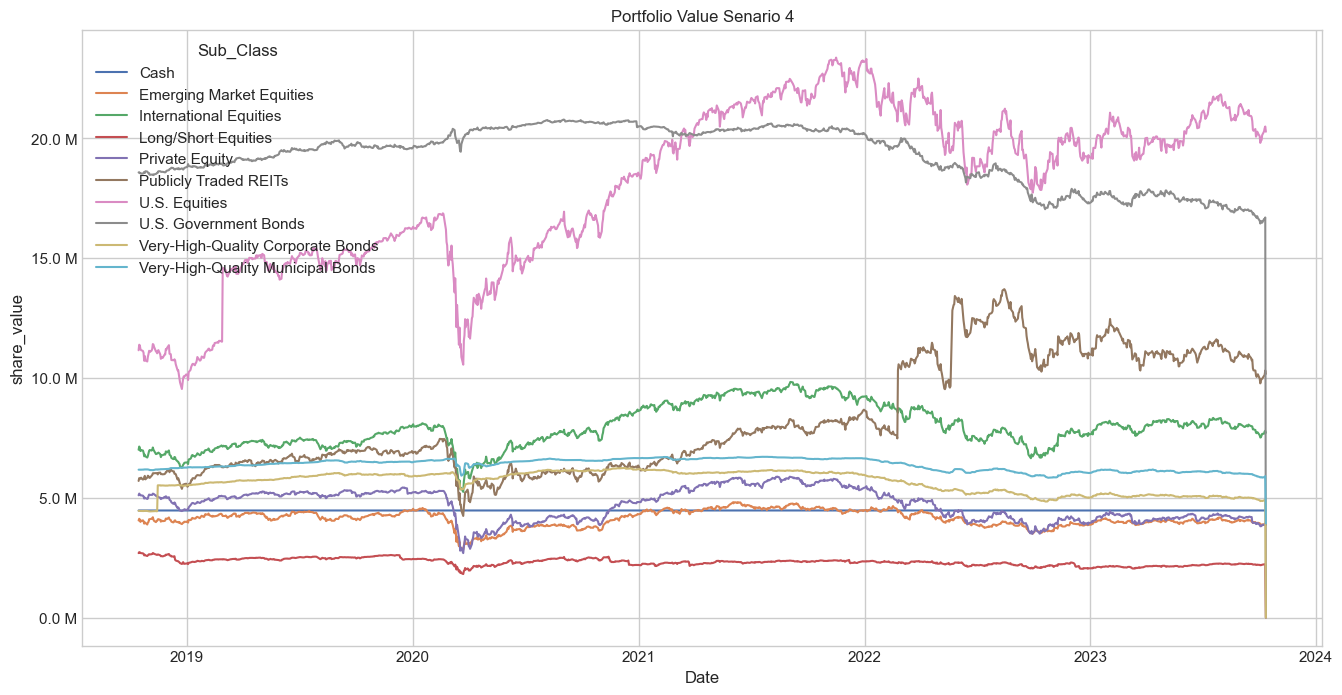

In [132]:
# Graph
fig, ax = plt.subplots(figsize=(16,8))
plt.ticklabel_format(style='plain', axis='y')

# Plot
sns.set_style("white")
g = sns.lineplot(data=t_df, x="Date", y="share_value", hue='Sub_Class')
g.set_yticklabels(['{:,.1f}'.format(x) + ' M' for x in g.get_yticks()/1000000])

ax.set(title='Portfolio Value Senario 4');

# Alpha Calculations

# Economically Sensitive

In [133]:
tickers='^DJA'
#tickers = 'FHNFX'
bench_data = pdr.get_data_yahoo(tickers=tickers, period=period)
bench_econ_df= pd.DataFrame(bench_data['Close'])
bench_econ_df.columns = ['bench']
bench_econ_df['precent_bench']= bench_econ_df['bench'].pct_change(1)

print('bench_econ_df:', bench_econ_df.shape)
#bench_econ_df

[*********************100%%**********************]  1 of 1 completed
bench_econ_df: (1257, 2)


In [134]:
ticker_lst = folio_econ_df['Ticker']
print('ticker_lst:', len(ticker_lst))

#value_econ_df = merge_df[merge_df['Ticker'].isin(ticker_lst)]
#print('value_econ_df:', value_econ_df.shape)

ticker_lst: 20


In [135]:
bench_econ_df

,bench,precent_bench
Date,,
2018-10-15,"8,406.2803",NaN
2018-10-16,"8,568.5195",0.0193
2018-10-17,"8,535.0703",-0.0039
2018-10-18,"8,413.0996",-0.0143
2018-10-19,"8,452.2998",0.0047
...,...,...
2023-10-06,"11,040.2402",0.0092
2023-10-09,"11,123.7100",0.0076
2023-10-10,"11,192.2500",0.0062


In [136]:
alpha_econ_df = pd.DataFrame(columns=['Ticker','alpha','beta'])

for t in ticker_lst:
    X = bench_econ_df['precent_bench'].values
    y = merge_df[merge_df['Ticker'] == t]['perc_share_value'].values
    
    t_df = pd.DataFrame({'X':X,'y':y})
    t_df = t_df[np.isfinite(t_df).all(1)]
    
    alpha, beta = linreg(t_df.X.values,t_df.y.values)
    alpha_econ_df.loc[len(alpha_econ_df.index)] = [t, alpha, beta]
    
print('alpha_econ_df:', alpha_econ_df.shape)

alpha_econ_df: (20, 3)


## Graph

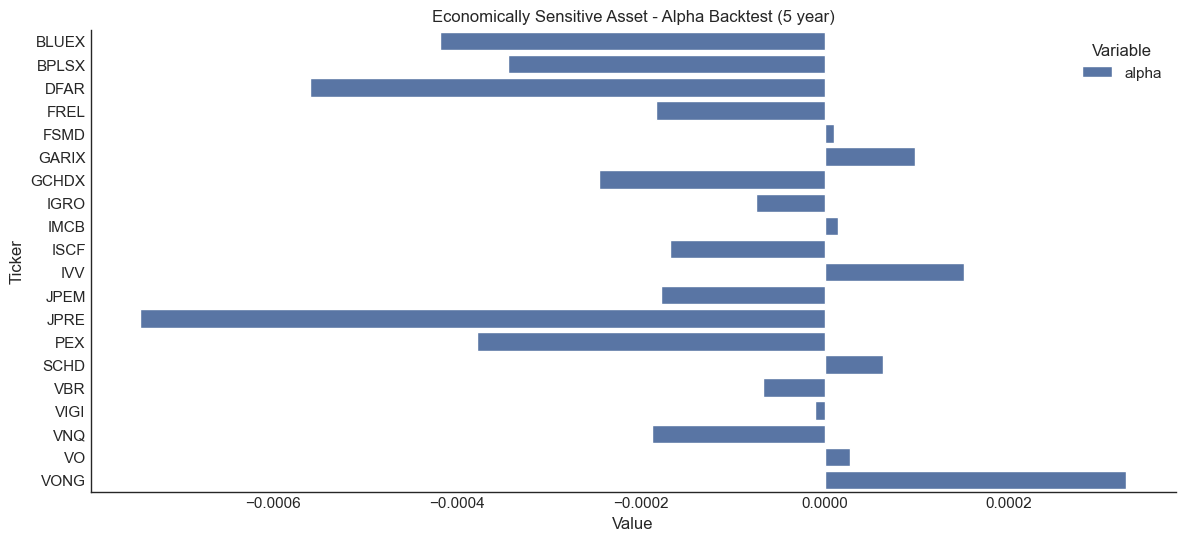

In [137]:
fig, ax = plt.subplots(figsize=(14,6))
t_df = alpha_econ_df.melt(id_vars='Ticker').rename(columns=str.title)
t_df = t_df[t_df['Variable'] == 'alpha']
g = sns.barplot(x='Value', y='Ticker', hue='Variable',data=t_df, ax=ax)
sns.despine(fig)
ax.set(title='Economically Sensitive Asset - Alpha Backtest (5 year)');

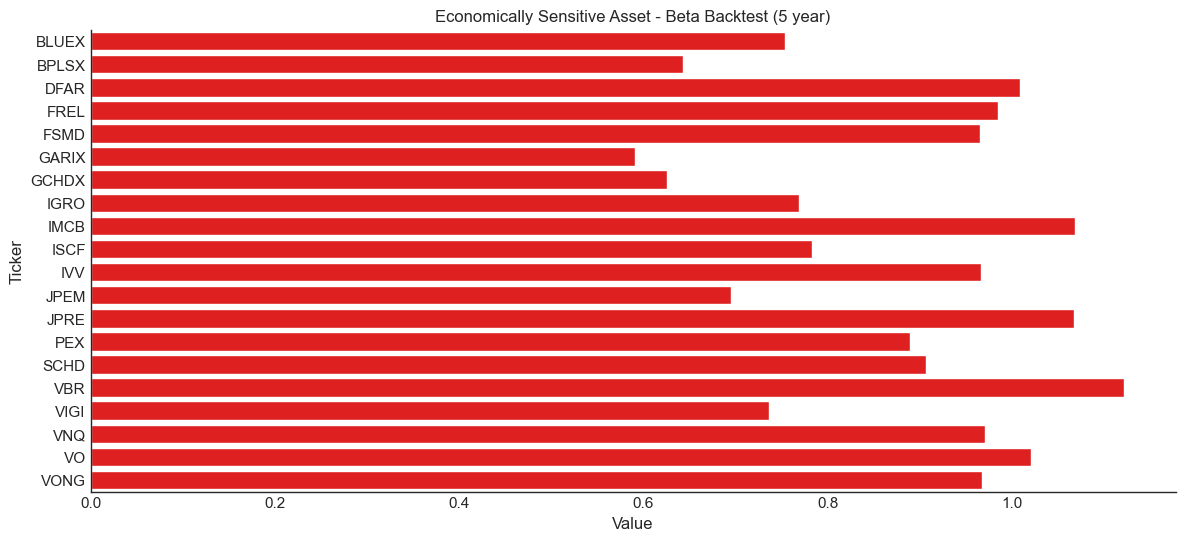

In [138]:
fig, ax = plt.subplots(figsize=(14,6))
t_df = alpha_econ_df.melt(id_vars='Ticker').rename(columns=str.title)
t_df = t_df[t_df['Variable'] == 'beta']
g = sns.barplot(x='Value', y='Ticker', color='red', data=t_df, ax=ax)
sns.despine(fig)
ax.set(title='Economically Sensitive Asset - Beta Backtest (5 year)');

# Interest Rate Sensitive

In [140]:
#tickers='^DJA'
tickers = 'FHNFX'
bench_data = pdr.get_data_yahoo(tickers=tickers, period=period)
bench_int_df= pd.DataFrame(bench_data['Close'])
bench_int_df.columns = ['bench']
bench_int_df['precent_bench']= bench_int_df['bench'].pct_change(1)

print('bench_int_df #:', bench_int_df.shape)
lb = len(bench_int_df)

[*********************100%%**********************]  1 of 1 completed
bench_int_df #: (1256, 2)


In [141]:
ticker_lst = folio_int_df['Ticker']
print('ticker_lst:', len(ticker_lst))

ticker_lst: 14


In [142]:
alpha_int_df = pd.DataFrame(columns=['Ticker','alpha','beta'])

for t in ticker_lst:
    X = bench_int_df['precent_bench'].values
    y = merge_df[merge_df['Ticker'] == t][:lb]['perc_share_value'].values
    
    t_df = pd.DataFrame({'X':X,'y':y})
    t_df = t_df[np.isfinite(t_df).all(1)]
    
    alpha, beta = linreg(t_df.X.values,t_df.y.values)
    alpha_int_df.loc[len(alpha_int_df.index)] = [t, alpha, beta]
    
print('alpha_int_df:', alpha_int_df.shape)

alpha_int_df: (14, 3)


## Graph

In [ ]:
fig, ax = plt.subplots(figsize=(14,6))
t_df = alpha_int_df.melt(id_vars='Ticker').rename(columns=str.title)
t_df = t_df[t_df['Variable'] == 'alpha']
g = sns.barplot(x='Value', y='Ticker', hue='Variable',data=t_df, ax=ax)
sns.despine(fig)
ax.set(title='Interest Sensitive Asset - Alpha Backtest (5 year)');

In [ ]:
fig, ax = plt.subplots(figsize=(14,6))
t_df = alpha_int_df.melt(id_vars='Ticker').rename(columns=str.title)
t_df = t_df[t_df['Variable'] == 'beta']
g = sns.barplot(x='Value', y='Ticker', color='red',data=t_df, ax=ax)
sns.despine(fig)
ax.set(title='Interest Sensitive Asset - Beta Backtest (5 year)');